In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [61]:
data = pd.read_csv('deltaRE_og_description.csv')

In [62]:
data.head()

,half_inning,Unnamed: 1,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,...,total_runs,half_inning.1,max_runs_in_half_inning,roi_score,count_state,state,runner_state,RE,next_runs,deltaRE
0,716352_1_Bot,11,SI,2023-10-01,92.0,-2.78,5.68,"King, Michael",672580,650633,...,0,716352_1_Bot,0,0,0&0,0&0_0_000,0,0.507947,0,-0.038179
1,716352_1_Bot,10,FF,2023-10-01,93.8,-2.55,5.86,"King, Michael",672580,650633,...,0,716352_1_Bot,0,0,0&1,0&1_0_000,0,0.469768,0,-0.052053
2,716352_1_Bot,9,FF,2023-10-01,94.3,-2.50,5.95,"King, Michael",672580,650633,...,0,716352_1_Bot,0,0,0&2,0&2_0_000,0,0.417715,0,-0.148449
3,716352_1_Bot,8,SI,2023-10-01,93.5,-2.60,5.68,"King, Michael",677951,650633,...,0,716352_1_Bot,0,0,0&0,0&0_1_000,0,0.269266,0,-0.028510
4,716352_1_Bot,7,SI,2023-10-01,94.0,-2.59,5.74,"King, Michael",677951,650633,...,0,716352_1_Bot,0,0,0&1,0&1_1_000,0,0.240756,0,0.020254


In [64]:
data['fielder_2'].unique()

array([669224, 521692, 571912, 668800, 686452, 518595, 596117, 682626,
       605421, 664954, 656024, 650907, 623168, 455117, 664874, 673237,
       680777, 553869, 642851, 641680, 663728, 620443, 666310, 668670,
       663743, 641511, 669257, 666165, 665804, 661388, 605170, 691016,
       681351, 657136, 543510, 543877, 660688, 669221, 672515, 669127,
       663886, 671056, 543228, 518735, 543309, 682515, 592663, 553882,
       624512, 668939, 607732, 682848, 595978, 595956, 608348, 605131,
       672275, 672386, 542194, 686676, 666163, 542208, 669134, 681807,
       680418, 595453, 575929, 669087, 645444, 657247, 663698, 666023,
       596142, 641598, 643376, 656180, 606992, 642136, 641470, 571466,
       608596, 680779, 595751, 642336, 592200, 624431, 543592, 444489,
       621532, 643348, 572287, 661531, 506702, 656627, 663967, 621512,
       668663, 608360, 644433, 669004, 650619, 547379], dtype=int64)

In [140]:
def custom_sigmoid(x, sz):
    return 1 / (1 + np.exp(-30 * (x - sz)))

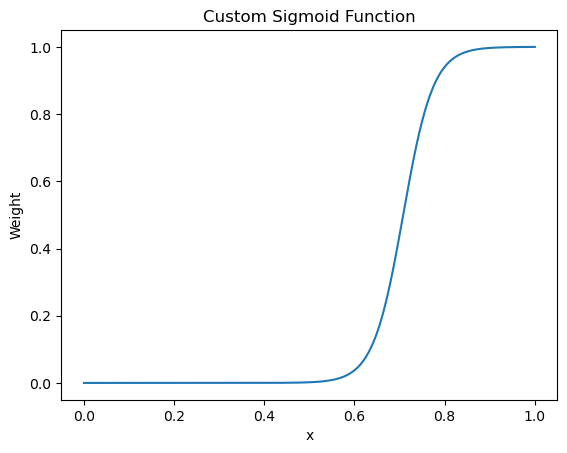

In [141]:
# Test the function
x_values = np.linspace(0, 1, 500)
y_values = custom_sigmoid(x_values, .708)

plt.plot(x_values, y_values)
plt.xlabel('x')
plt.ylabel('Weight')
plt.title('Custom Sigmoid Function')
plt.show()

In [142]:
df = data.copy()

In [143]:
# Calculate the midpoint of the strike zone
df['sz_mid'] = (df['sz_top'] + df['sz_bot']) / 2

# Apply the custom sigmoid function based on conditions for plate_x
df['sigmoid_x'] = df['plate_x'].apply(lambda x: custom_sigmoid(x, -0.708) if x < 0 else custom_sigmoid(x, 0.708))

# Apply the custom sigmoid function based on conditions for plate_z
df['sigmoid_z'] = df.apply(lambda row: custom_sigmoid(row['plate_z'], row['sz_top']) if row['plate_z'] >= row['sz_mid'] else custom_sigmoid(row['plate_z'], row['sz_bot']), axis=1)

# Calculate the sum of squares for sigmoid_x and sigmoid_z
df['sum_of_squares'] = df['sigmoid_x']**2 + df['sigmoid_z']**2

# Calculate the square root of the sum of squares
df['sqrt_sum_of_squares'] = np.sqrt(df['sum_of_squares'])

# Normalize the square root of sum of squares
min_val = df['sqrt_sum_of_squares'].min()
max_val = df['sqrt_sum_of_squares'].max()
df['normalized_sqrt_sum_of_squares'] = (df['sqrt_sum_of_squares'] - min_val) / (max_val - min_val)

In [144]:
df.loc[df['description'] == 'ball', 'normalized_sqrt_sum_of_squares'] = df.loc[df['description'] == 'ball', 'normalized_sqrt_sum_of_squares'] - 1

<Axes: >

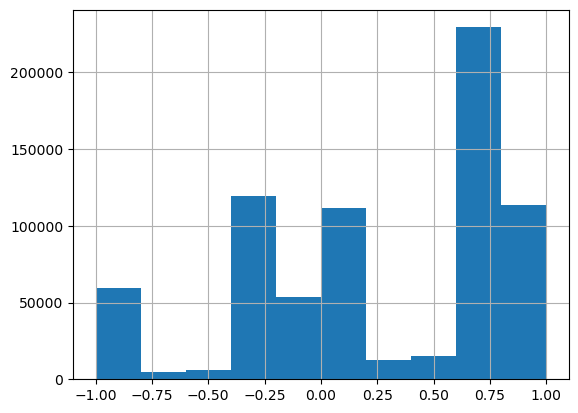

In [145]:
df['normalized_sqrt_sum_of_squares'].hist()

In [146]:
df['description'].value_counts()


description
ball                       243446
foul                       129398
hit_into_play              125641
called_strike              119250
swinging_strike             77250
blocked_ball                16157
foul_tip                     7349
swinging_strike_blocked      4386
hit_by_pitch                 2132
foul_bunt                    1012
missed_bunt                   185
pitchout                       46
bunt_foul_tip                  16
unknown_strike                  1
Name: count, dtype: int64

In [147]:
# Balls that should have been called strikes
balls_should_be_strikes = df.loc[
    ((df['plate_z'] >= df['sz_bot']) & 
     (df['plate_z'] <= df['sz_top']) & 
     (abs(df['plate_x']) <= 0.708) & 
     (df['description'] == 'ball'))
].copy()

print("Balls that should be strikes description counts:")
print(balls_should_be_strikes['description'].value_counts())

# Strikes that should have been called balls
strikes_should_be_balls = df.loc[
    (
        (df['plate_z'] < df['sz_bot']) | 
        (df['plate_z'] > df['sz_top']) | 
        (abs(df['plate_x']) > 0.708)
    ) & 
    (df['description'] == 'called_strike')
].copy()

print("Strikes that should be balls description counts:")
print(strikes_should_be_balls['description'].value_counts())

# Concatenating the two DataFrames
catcher = pd.concat([balls_should_be_strikes, strikes_should_be_balls])

print("Combined DataFrame description counts:")
print(catcher['description'].value_counts())


Balls that should be strikes description counts:
description
ball    3999
Name: count, dtype: int64
Strikes that should be balls description counts:
description
called_strike    34678
Name: count, dtype: int64
Combined DataFrame description counts:
description
called_strike    34678
ball              3999
Name: count, dtype: int64


In [148]:
catcher['framing_runs'] = catcher['normalized_sqrt_sum_of_squares'] * catcher['deltaRE']

In [159]:
player_query = pd.read_csv('player_query.csv')

In [160]:
merge = pd.merge(catcher, player_query, left_on='fielder_2', right_on='mlb_id', how='left')

In [161]:
merge.groupby('mlb_name')['framing_runs'].sum().sort_values(ascending=True)

mlb_name
Jonah Heim          -44.152098
Shea Langeliers     -40.685290
J.T. Realmuto       -40.403430
William Contreras   -37.400092
Keibert Ruiz        -37.034412
                       ...    
Luis Torrens         -0.276593
Manny Pina           -0.173478
Chris Okey           -0.091353
Zack Collins         -0.072342
Henry Davis          -0.018005
Name: framing_runs, Length: 101, dtype: float64

In [162]:
merge['framing_runs'] = merge['framing_runs'] * -1

In [163]:
merge.groupby('mlb_name')['framing_runs'].sum().sort_values(ascending=False).to_csv('catcher_framing.csv')